In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import requests as req
import json

from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

new_path = os.getcwd().replace('/notebooks', '')
print(f'Adding {new_path} to sys.path')

if new_path not in sys.path:
    sys.path.append(new_path)

# Local imports
from curvemetrics.src.classes.datahandler import DataHandler
from curvemetrics.src.classes.datafetcher import DataFetcher
from curvemetrics.src.classes.metricsprocessor import MetricsProcessor

Adding /root/curve-lp-metrics to sys.path


In [3]:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 10})

In [4]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()

pool = "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7" # 3pool

start_ts, start_block = DataFetcher.get_block(datetime.fromisoformat("2023-03-01"))
end_ts, end_block = DataFetcher.get_block(datetime.fromisoformat("2023-04-01"))

In [6]:
swaps_data = datahandler.get_swaps_data(pool, start_ts, end_ts)
# lp_data = datahandler.get_lp_data(pool, start_ts, end_ts)
# pool_data = datahandler.get_pool_data(pool, start_ts, end_ts)

tokens = {token_metadata[v]['symbol']:v for v in set(swaps_data['tokenBought'])}
tokens

{'USDT': '0xdac17f958d2ee523a2206206994597c13d831ec7',
 'DAI': '0x6b175474e89094c44da98b954eedeac495271d0f',
 'USDC': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'}

In [7]:
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata)

In [8]:
ohlcvs = {}
for k, v in tokens.items():
    if k == "3Crv":
        continue
    ohlcv = datahandler.get_ohlcv_data(v, start=start_ts, end=end_ts)
    ohlcvs[v] = ohlcv

<Axes: xlabel='timestamp'>

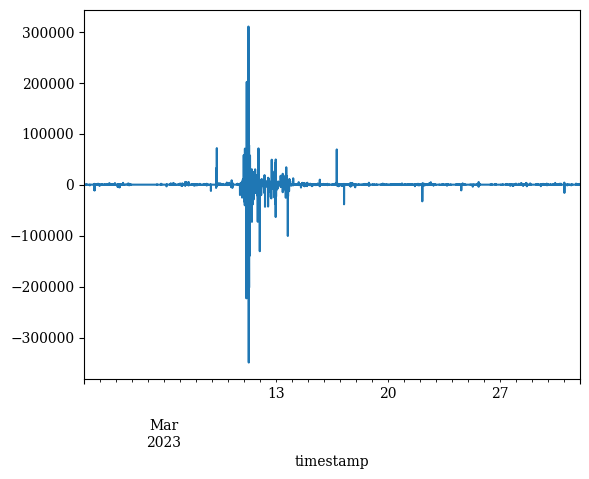

In [14]:
markouts = MetricsProcessor.markout(swaps_data, ohlcvs, window=timedelta(minutes=5), who='lp', freq='1min')
markouts.plot()

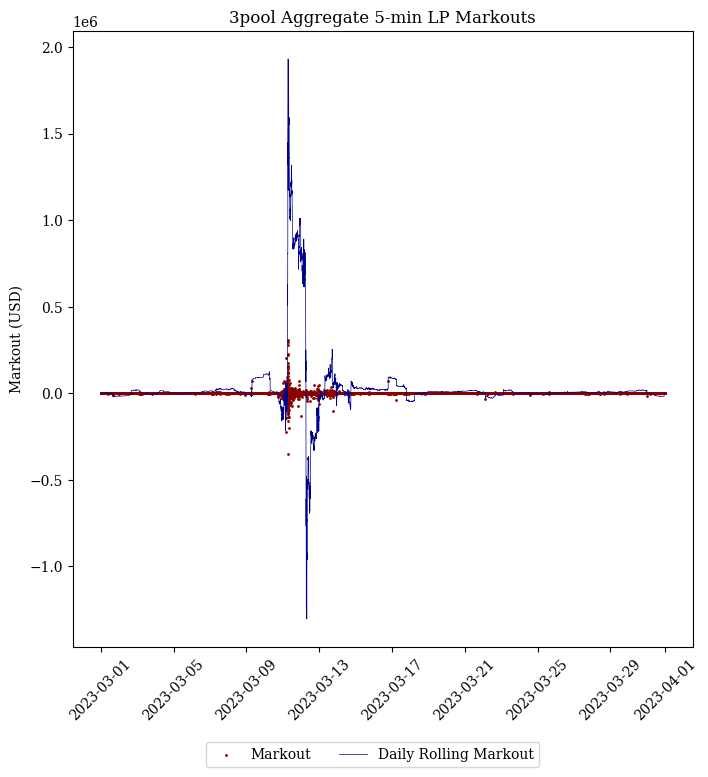

In [71]:
min5_markouts = MetricsProcessor.markout(swaps_data, ohlcvs, window=timedelta(minutes=5), who='lp')

rolling = min5_markouts.rolling('1d').sum()

f, ax = plt.subplots(figsize=(8,8))

ax.scatter(min5_markouts.index, min5_markouts, c='darkred', s=1, label='Markout')
ax.plot(rolling.index, rolling, c='darkblue', linewidth=0.5, label='Daily Rolling Markout')

ax.set_title(f'3pool Aggregate 5-min LP Markouts')
ax.tick_params(axis="x", rotation=45)
ax.set_ylabel('Markout (USD)')

f.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)
f.savefig('../figs/3crv_lp_markouts_5min.png', bbox_inches='tight')

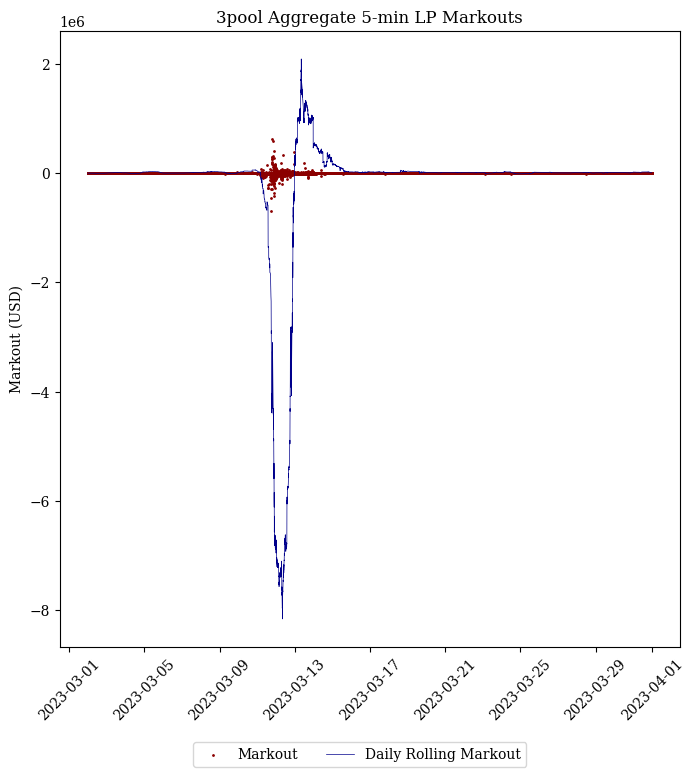

In [70]:
days1_markouts = MetricsProcessor.markout(swaps_data, ohlcvs, window=timedelta(days=1), who='lp')

rolling = days1_markouts.rolling('1d').sum()

f, ax = plt.subplots(figsize=(8,8))

ax.scatter(days1_markouts.index, days1_markouts, c='darkred', s=1, label='Markout')
ax.plot(rolling.index, rolling, c='darkblue', linewidth=0.5, label='Daily Rolling Markout')

ax.set_title(f'3pool Aggregate 5-min LP Markouts')
ax.tick_params(axis="x", rotation=45)
ax.set_ylabel('Markout (USD)')

f.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)
f.savefig('../figs/3crv_lp_markouts_1d.png', bbox_inches='tight')

In [75]:
hours1_markouts = MetricsProcessor.markout(swaps_data, ohlcvs, window=timedelta(hours=1), who='lp')

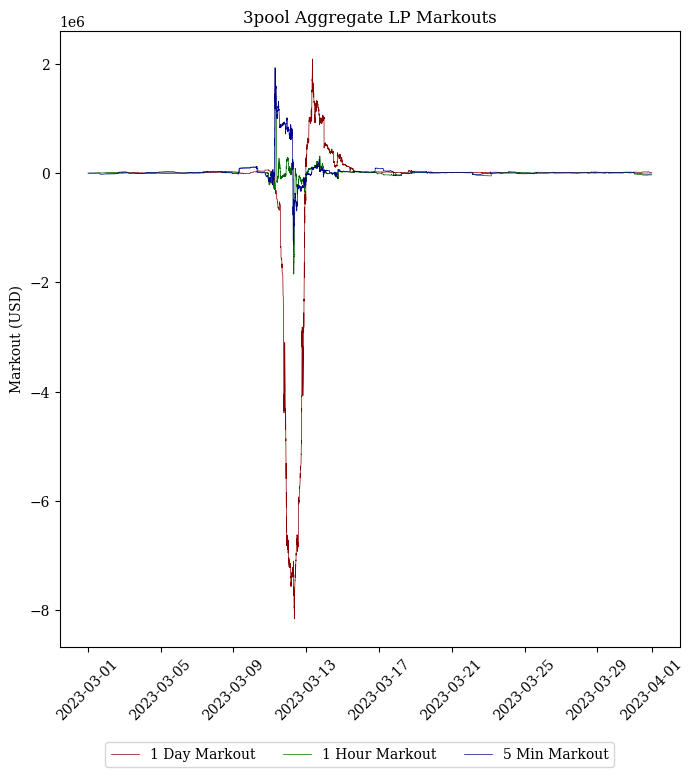

In [77]:
f, ax = plt.subplots(figsize=(8,8))

rolling1d = days1_markouts.rolling('1d').sum()
rolling1h = hours1_markouts.rolling('1d').sum()
rolling5m = min5_markouts.rolling('1d').sum()

ax.plot(rolling1d.index, rolling1d, c='darkred', linewidth=0.5, label='1 Day Markout')
ax.plot(rolling1h.index, rolling1h, c='darkgreen', linewidth=0.5, label='1 Hour Markout')
ax.plot(rolling5m.index, rolling5m, c='darkblue', linewidth=0.5, label='5 Min Markout')

ax.set_title(f'3pool Aggregate LP Markouts')
ax.tick_params(axis="x", rotation=45)
ax.set_ylabel('Markout (USD)')

f.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3)
f.savefig('../figs/3crv_lp_markouts.png', bbox_inches='tight')